
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

#### Importação de bibliotecas

In [45]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from gensim.models import KeyedVectors
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, Flatten, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

In [3]:
embedding_model = KeyedVectors.load_word2vec_format('../embeddings/wiki.pt.vec')

In [17]:
df = pd.read_csv('../datasets/buscape_preprocessed.csv')

In [18]:
df.shape

(133632, 2)

In [19]:
df.head(3)

,review_text,rating
0,estou muito satisfeito o visor e melhor do que...,1
1,muito boa o que gostei preco o que nao gostei ...,1
2,rapida otima qualidade de impressao e facil de...,1


In [20]:
df['rating'].value_counts()

rating
1    66816
0    66816
Name: count, dtype: int64

In [21]:
texts = df.review_text
labels = df.rating

In [22]:
def get_average_embedding(text):
    words = str(text).split()
    embeddings = [embedding_model[word] for word in words if word in embedding_model]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(embedding_model.vector_size)

In [47]:
X_embeddings = np.array([get_average_embedding(text) for text in texts])

In [48]:
print(f'{X_embeddings.shape[0]} sentenças, {X_embeddings.shape[1]} dimensoes')

133632 sentenças, 300 dimensoes


In [49]:
DROPOUT = 0.05 # 5%, 15%, 25%, 35%, and 50%
LEARNING_RATE = 5e-4 # 5e-4, 1e-3, 5e-3, 1e-2
K_FOLDS = 10
EPOCHS = 5
LOSS = 'binary_crossentropy'
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['accuracy']
BATCH_SIZE = 32
EARLY_STOP = EarlyStopping(monitor='val_loss', patience=3)
CALLBACKS = [EARLY_STOP]
VERBOSE=0

In [50]:
model = Sequential()
model.add(Input(300,)),
model.add(Dense(24, activation='relu')),
model.add(Dropout(DROPOUT)),
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 24)                7224      
                                                                 
 dropout_5 (Dropout)         (None, 24)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 25        
                                                                 
Total params: 7,249
Trainable params: 7,249
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)

In [52]:
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

In [54]:
fold = 0

train_loss_history = []
train_accuracies = []
train_f1_scores = []

val_f1_scores = []
val_accuracies = []
for train_idx, val_idx in tqdm(skf.split(X_embeddings, labels),desc='Processing'):
    fold += 1
    print(f'fold ---> {fold}')
    
    X_train, X_val = X_embeddings[train_idx], X_embeddings[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]

    model_history = model.fit(
        X_train, 
        y_train, 
        verbose=VERBOSE, 
        batch_size=BATCH_SIZE,  
        epochs=EPOCHS,
        validation_data=(X_train, y_train),
        callbacks=CALLBACKS
    )
    
    train_loss_history.append(model_history.history['loss'])
    train_accuracies.append(model_history.history['accuracy'])
    
    y_pred_train = (model.predict(X_train) > 0.5).astype(int)
    
    train_f1_score = f1_score(y_train, y_pred_train)
    train_f1_scores.append(train_f1_score)
    
    y_pred = (model.predict(X_val) > 0.5).astype(int)
    
    val_fold_f1_score = f1_score(y_val, y_pred)
    val_f1_scores.append(val_fold_f1_score)
    
    val_accuracy = accuracy_score(y_val, y_pred)
    val_accuracies.append(val_accuracy)

print('Finished!')

Processing: 0it [00:00, ?it/s]

fold ---> 1
418/418 [==============================] - 0s 693us/step


Processing: 1it [00:36, 36.06s/it]

fold ---> 2
418/418 [==============================] - 0s 713us/step


Processing: 2it [01:11, 35.41s/it]

fold ---> 3
418/418 [==============================] - 0s 721us/step


Processing: 3it [01:45, 34.96s/it]

fold ---> 4
418/418 [==============================] - 0s 717us/step


Processing: 4it [02:19, 34.76s/it]

fold ---> 5
418/418 [==============================] - 0s 706us/step


Processing: 5it [02:54, 34.56s/it]

fold ---> 6
418/418 [==============================] - 0s 711us/step


Processing: 6it [03:28, 34.48s/it]

fold ---> 7
418/418 [==============================] - 0s 741us/step


Processing: 7it [04:02, 34.44s/it]

fold ---> 8
418/418 [==============================] - 0s 718us/step


Processing: 8it [04:37, 34.42s/it]

fold ---> 9
418/418 [==============================] - 0s 727us/step


Processing: 9it [05:11, 34.36s/it]

fold ---> 10
418/418 [==============================] - 0s 712us/step


Processing: 10it [05:45, 34.57s/it]

Finished!


In [55]:
print('-'*80)
print(f'mean_train_loss = {round(np.mean(train_loss_history),4)}')
print(f'mean_train_accuracy = {round(np.mean(train_accuracies),4)}')
print(f'mean_train_f1_score = {round(np.mean(train_f1_scores),4)}')
print('-'*40)
print(f'mean_val_accuracy = {round(np.mean(val_accuracies),4)}')
print(f'mean_val_f1_score = {round(np.mean(val_f1_scores), 4)}')

--------------------------------------------------------------------------------
mean_train_loss = 0.3231
mean_train_accuracy = 0.864
mean_train_f1_score = 0.8743
----------------------------------------
mean_val_accuracy = 0.868
mean_val_f1_score = 0.8708


In [56]:
graph_path = './graphs/03_fasttext_mlp/'

In [70]:
def plot_eval_metrics(model, metric):
    plt.plot(model.history[metric])
    plt.plot(model.history[f'val_{metric}'])
    plt.title(f'model {metric}')
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(f'{graph_path}train_test_{metric}.png')
    plt.show()
    
def plot_k_folds_metrics(history, metric):
    plt.figure(figsize=(10, 6))
    for fold_num, fold_loss in enumerate(history):
        plt.plot(fold_loss, label=f'Fold {fold_num+1}')
    plt.xlabel('Epoch')
    plt.ylabel(f'Training {metric}')
    plt.title(f'Training {metric} per Epoch for Each Fold')
    plt.legend()
    plt.savefig(f'{graph_path}folds_{metric}.png')
    plt.show()
    
def plot_train_f1_score(metrics_list, k_folds_list, metric_name):
    folds = list(range(1,k_folds_list+1))
    val_acc = metrics_list
    plt.figure(figsize=(6, 4))
    plt.plot(folds, val_acc, marker='o')
    plt.title(f'Train {metric_name} Over Folds')
    plt.xlabel('Folds')
    plt.ylabel(f'Train {metric_name}')
    plt.grid(True)
    plt.xticks(folds)
    plt.ylim(0.8, 1.0)
    plt.savefig(f'{graph_path}f1_sc_{metric_name}.png')
    plt.show()
    
def plot_validation_graphs(metrics_list, k_folds_list, metric_name):
    folds = list(range(1,k_folds_list+1))
    val_acc = metrics_list
    plt.figure(figsize=(6, 4))
    plt.plot(folds, val_acc, marker='o')
    plt.title(f'Validation {metric_name} Over Folds')
    plt.xlabel('Folds')
    plt.ylabel(f'Validation {metric_name}')
    plt.grid(True)
    plt.xticks(folds)
    plt.ylim(0.8, 1.0)
    plt.savefig(f'{graph_path}val_f1_{metric_name}.png')
    plt.show()

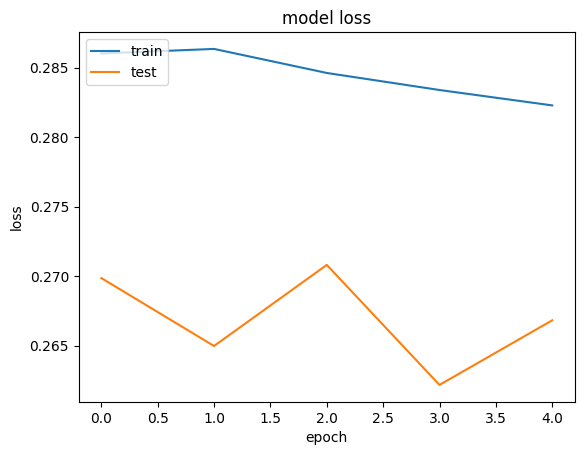

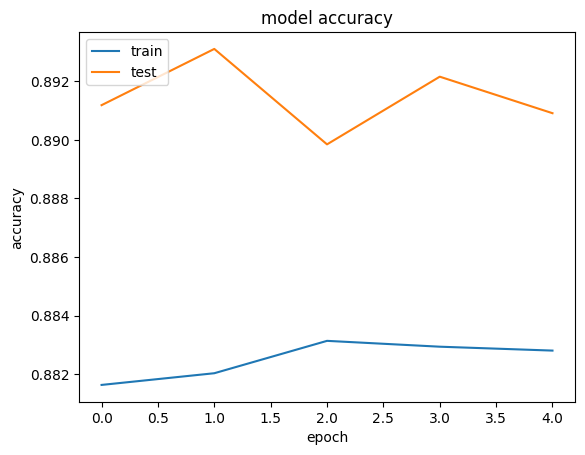

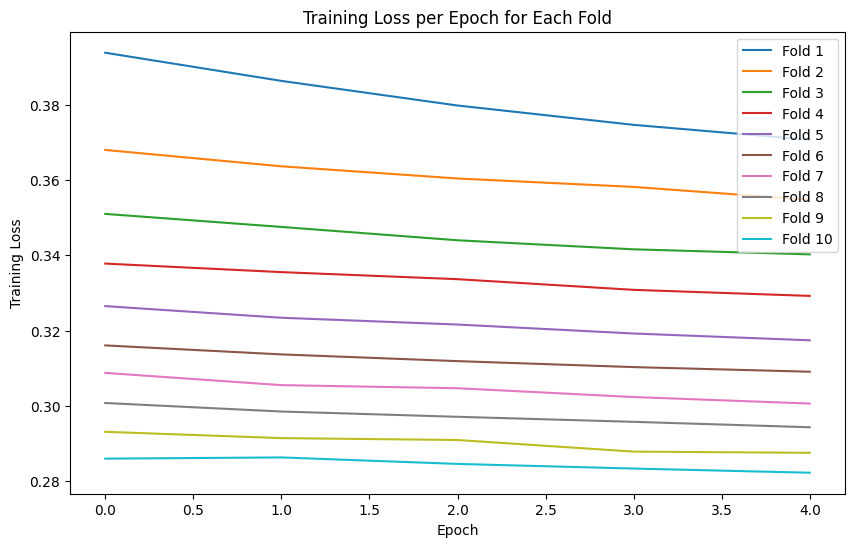

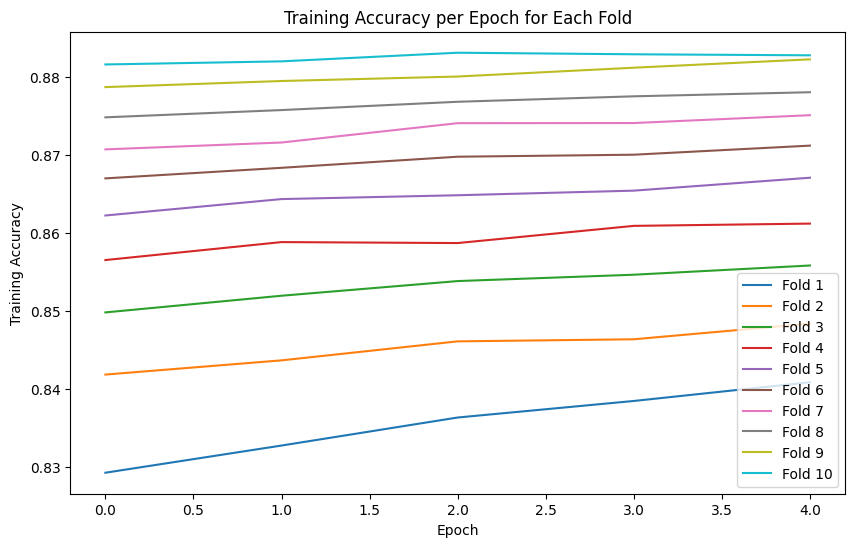

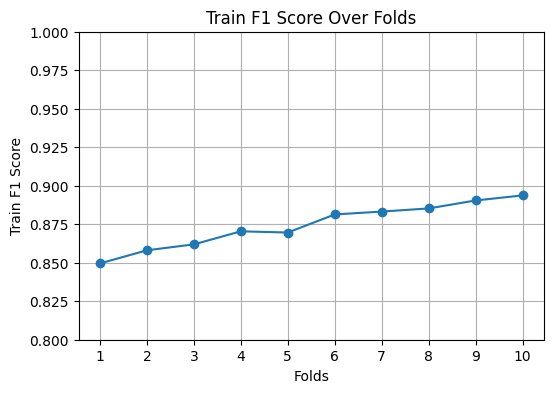

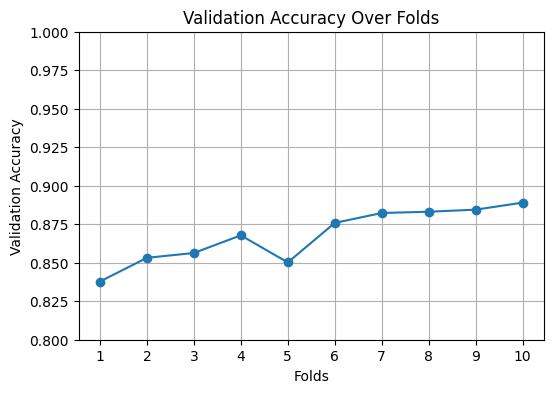

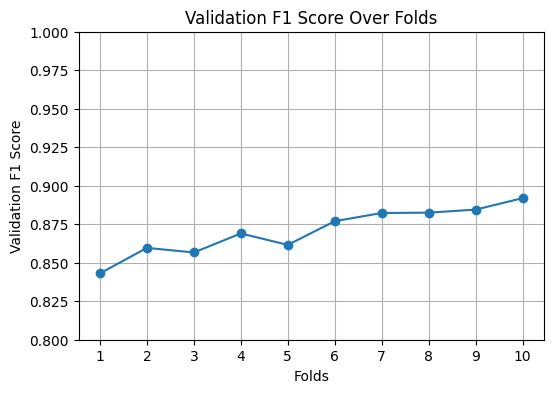

In [71]:
plot_eval_metrics(model_history, 'loss')
plot_eval_metrics(model_history, 'accuracy')

plot_k_folds_metrics(train_loss_history, 'Loss')
plot_k_folds_metrics(train_accuracies, 'Accuracy')

plot_train_f1_score(train_f1_scores, K_FOLDS, 'F1 Score')

plot_validation_graphs(val_accuracies, K_FOLDS, 'Accuracy')
plot_validation_graphs(val_f1_scores, K_FOLDS, 'F1 Score')